In [39]:
import pandas as pd
import numpy as np

In [337]:
data = pd.read_csv('/Users/haixiangliu/Documents/水质数据及代码模型/water_clean_data_2hour.csv')

In [338]:
data.columns = ['id','datetime','water_level','do','miss','input_wind_throughput','input_wind_openness','ts','input_water_cod','output_water_cod','input_water_ammonia','output_water_ammonia','input_water_ph','output_water_phosphorus','input_water_ss','output_water_ss','label']

In [339]:
data[['input_wind_throughput','input_wind_openness','input_water_cod','output_water_cod','output_water_ammonia','input_water_ss','output_water_ss','label']]=data[['input_wind_throughput','input_wind_openness','input_water_cod','output_water_cod','output_water_ammonia','input_water_ss','output_water_ss','label']].astype(float)

In [340]:
data.columns

Index(['id', 'datetime', 'water_level', 'do', 'miss', 'input_wind_throughput',
       'input_wind_openness', 'ts', 'input_water_cod', 'output_water_cod',
       'input_water_ammonia', 'output_water_ammonia', 'input_water_ph',
       'output_water_phosphorus', 'input_water_ss', 'output_water_ss',
       'label'],
      dtype='object')

In [341]:
data['year'] = pd.to_datetime(data['datetime']).dt.year
data['month'] = pd.to_datetime(data['datetime']).dt.month
data['weekofyear'] = pd.to_datetime(data['datetime']).dt.weekofyear
data['dayofmonth'] = pd.to_datetime(data['datetime']).dt.day
data['hour'] = pd.to_datetime(data['datetime']).dt.hour
data[['year','month','weekofyear','hour']]= data[['year','month','weekofyear','hour']].astype(float)


In [342]:
len(data.columns)

22

In [343]:
rolling_features_input_cols = ['do', 'miss', 'input_wind_throughput', 'input_wind_openness',
                    'input_water_cod', 'output_water_cod', 'input_water_ammonia', 
                    'output_water_ammonia', 'input_water_ph', 'output_water_phosphorus', 
                    'input_water_ss', 'output_water_ss','label']
lags = [3, 7, 14, 30]

In [344]:
len(data.columns)

22

In [345]:
data_basic=data.sort_values(by=['datetime'])
data=data.sort_values(by=['datetime'])

In [346]:
#均值
for lag_n in lags:
    for col_name in rolling_features_input_cols:
        data_basic[col_name+'_rollingmean_'+str(lag_n)]=data[col_name].rolling(window=lag_n,min_periods=1).mean()

water_rollingmean=data_basic[['ts']+list(s for s in data_basic.columns if 'rollingmean' in s)]

In [347]:
#最小值
for lag_n in lags:
    for col_name in rolling_features_input_cols:
        data_basic[col_name+'_rollingmin_'+str(lag_n)]=data[col_name].rolling(window=lag_n,min_periods=1).min()
water_rollingmin=data_basic[['ts']+list(s for s in data_basic.columns if 'rollingmin' in s)]

In [348]:
len(water_rollingmin.columns)

53

In [349]:
#最大值
for lag_n in lags:
    for col_name in rolling_features_input_cols:
        data_basic[col_name+'_rollingmax_'+str(lag_n)]=data[col_name].rolling(window=lag_n,min_periods=1).max()
water_rollingmax=data_basic[['ts']+list(s for s in data_basic.columns if 'rollingmax' in s)]

In [350]:
len(water_rollingmax.columns)

53

In [351]:
#标准差
for lag_n in lags:
    for col_name in rolling_features_input_cols:
        data_basic[col_name+'_rollingstd_'+str(lag_n)]=data[col_name].rolling(window=lag_n,min_periods=1).std()
water_rollingstd=data_basic[['ts']+list(s for s in data_basic.columns if 'rollingstd' in s)]

In [353]:
#初值-均值
lags = [3,7]
for lag_n in lags:
    for col_name in rolling_features_input_cols:
        data_basic[col_name+'_rollingdiff_'+str(lag_n)]=data[col_name]-data[col_name].rolling(window=lag_n,min_periods=1).mean()
water_rollingdiff=data_basic[['ts']+list(s for s in data_basic.columns if 'rollingdiff' in s)]

In [354]:
len(water_rollingdiff.columns)

27

In [355]:
data_all = pd.merge(data,water_rollingmean,on=['ts'])\
                .merge(water_rollingmin,on=['ts'])\
                .merge(water_rollingmax,on=['ts'])\
                .merge(water_rollingstd,on=['ts'])\
                .merge(water_rollingdiff,on=['ts'])

In [356]:
len(data_all.columns)

256

In [357]:
#a=[]
#for i in data_all['output_water_cod']:
 #   a.append(i)
#a=a[5:34035]
#data_all_label = data_all.drop([34031,34032,34033,34030,34034])
#data_all_label['label_5']=a

In [358]:
#data_all_label=data_all_label.fillna(data_all_label.mean())

In [359]:
data_all_label=data_all

In [361]:
train = data_all_label.loc[data_all_label['datetime']<"2016-01-01 00:00:00"]
test = data_all_label.loc[data_all_label['datetime']> "2015-12-31 23:59:59"]

In [363]:
train.shape,test.shape

((25442, 256), (8593, 256))

In [364]:
rolling_features = [col for col in data_all_label.columns if "_rolling" in col]
excluded_cols = ['datetime', 'ts', 'output_water_cod', 'label','id']
basic_features = [col for col in data_all_label.columns if col not in rolling_features + excluded_cols]

In [365]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Imputer 
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

In [366]:
features=rolling_features+basic_features

In [367]:
train = train.fillna(train.mean())

In [368]:
def my_scaler(df):
    df_norm = (df - df.mean()) / (df.std())
    df_norm = df_norm.fillna(0.0)
    return df_norm

In [369]:
train[rolling_features] = my_scaler(train[rolling_features])

In [370]:
train[rolling_features].head()

,do_rollingmean_3,miss_rollingmean_3,input_wind_throughput_rollingmean_3,input_wind_openness_rollingmean_3,input_water_cod_rollingmean_3,output_water_cod_rollingmean_3,input_water_ammonia_rollingmean_3,output_water_ammonia_rollingmean_3,input_water_ph_rollingmean_3,output_water_phosphorus_rollingmean_3,...,input_wind_openness_rollingdiff_7,input_water_cod_rollingdiff_7,output_water_cod_rollingdiff_7,input_water_ammonia_rollingdiff_7,output_water_ammonia_rollingdiff_7,input_water_ph_rollingdiff_7,output_water_phosphorus_rollingdiff_7,input_water_ss_rollingdiff_7,output_water_ss_rollingdiff_7,label_rollingdiff_7
0,1.926914,-1.504207,-1.529214,-1.835000,-0.309321,1.513831,-2.996960,1.668080,-0.34016,0.834775,...,-0.000123,0.000039,-0.000014,-0.000513,0.000708,-0.000488,0.000517,0.001025,0.000230,-7.681302e-05
1,1.694344,-1.503074,-1.529214,-1.835000,0.018520,1.320073,-3.049086,1.603794,-0.34016,0.834775,...,-0.000123,0.439515,-0.284758,-0.085791,-0.191440,-0.000488,0.000517,-5.170680,-0.594740,-7.681302e-05
2,1.423012,-1.506474,-1.529214,-1.835000,0.063353,1.255487,-3.066462,1.582365,-0.34016,0.834775,...,-0.000123,0.120238,-0.189843,-0.057365,-0.127391,-0.000488,0.000517,-3.286208,-0.396416,4.011335e-01
3,2.004437,-1.306111,0.128072,-0.494068,0.141811,1.255487,-3.031711,1.582365,-0.34016,0.834775,...,1.656099,-0.138001,0.284731,0.212681,0.192857,-0.000488,0.000517,-4.300924,0.595200,-4.697926e-18
4,2.547100,-1.102425,1.812568,0.846864,0.231477,1.384659,-2.475695,1.625222,-0.34016,0.834775,...,1.324854,0.628828,0.227782,2.080260,0.154427,-0.000488,0.000517,-4.275500,0.952182,3.008309e-01


In [371]:
model = RandomForestRegressor(n_estimators=100,max_depth=5).fit(train[features],train['label'])

In [372]:
predictions = model.predict(train[features])

In [373]:
print('Root Train Error : '+str(np.sqrt(mean_squared_error(train['label'],predictions))))

Root Train Error : 1.3935050032160052


In [374]:
test = test.fillna(test.mean())
test[rolling_features] = my_scaler(test[rolling_features])

In [375]:
predictions_test = model.predict(test[features])

In [376]:
print('Root Test Error : '+str(np.sqrt(mean_squared_error(test['label'],predictions_test))))

Root Test Error : 1.4371520026599478


In [377]:
%matplotlib inline 
import matplotlib.pyplot as plt

In [378]:
predictions= predictions[0:500]
train_label=[]
num=0
for i in train['label'].head(500).astype(float):
     train_label.append(i)

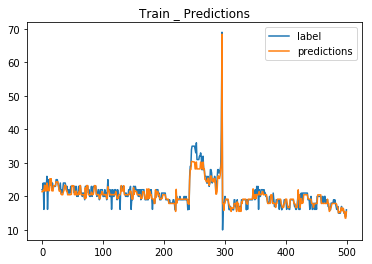

In [379]:
plt.plot(train_label,label='label')
plt.plot(predictions,label='predictions')
plt.rcParams['figure.figsize'] = (18.0, 6.0)
plt.title('Train _ Predictions')
plt.legend()

In [380]:
predictions_label = predictions_test[0:500]
test_label=[]
num=0
for i in test['label'].head(500).astype(float):
     test_label.append(i)

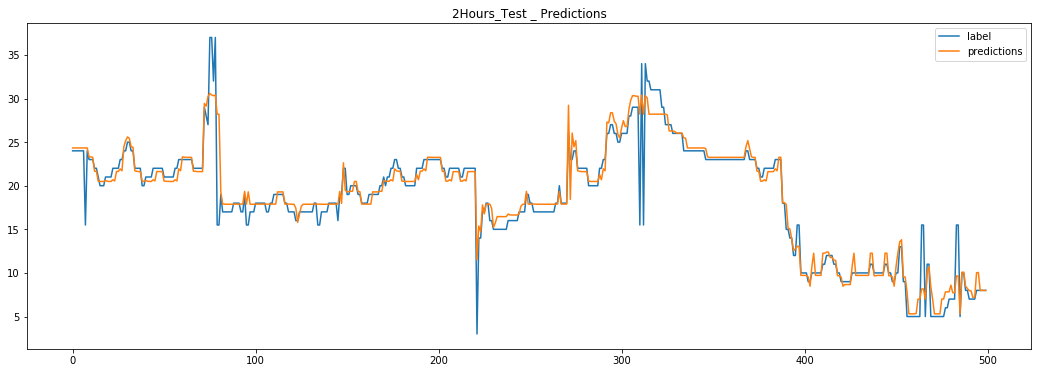

In [381]:
#print('Mean Squared Error (RMSE) -- Train : '+str(mean_squared_error(train['label_5'],predictions)))
#print('Mean Squared Error (RMSE) -- Test : '+str(mean_squared_error(test['label_5'],predictions_test)))
plt.plot(test_label,label='label')
plt.plot(predictions_label,label='predictions')
plt.rcParams['figure.figsize'] = (18.0, 6.0)
plt.title('2Hours_Test _ Predictions')
plt.legend()